<a href="https://colab.research.google.com/github/Sarah-Shitrit/bird_localization/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and downloads

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_video
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import pandas as pd


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Important! Insert the path to the folder in which the models' parameters are saved
models_path = '/content/drive/MyDrive/Deep Learning Course/project_207028614_313472417'

lab_dir = os.path.join(models_path, "Recordings_22.5", "Lab_webm")
ronen_dir = os.path.join(models_path, "Recordings_22.5", "Ronen_webm")
labels_csv = os.path.join(models_path, "Recordings_22.5", "labels.xlsx")

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('Running on CUDA')
else:
    print('Running on CPU')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Running on CUDA


# Data Loader & Preprocessing

In [5]:
# Helpful Functions

def plot_labels(train_labels, test_labels):
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the training set labels in blue
    ax.scatter(train_labels['x'], train_labels['y'], train_labels['z'], color='b', alpha=0.5, label='Train')

    # Plot the test set labels in red
    ax.scatter(test_labels['x'], test_labels['y'], test_labels['z'], color='r', alpha=0.5, label='Test')

    # Set the labels of the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set the title of the plot
    ax.set_title('Label Distribution')

    # Add a legend
    ax.legend()

    plt.show()

def display_random_frame(dataset):
    # Get a random index
    idx = random.randint(0, len(dataset) - 1)

    # Get the videos and label at this index
    lab_video, ronen_video, label = dataset[idx]

    # Get the first frame of each video
    lab_frame = lab_video[0]
    ronen_frame = ronen_video[0]

    # Display the frames
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(lab_frame)
    axs[0].set_title('Lab Frame')

    axs[1].imshow(ronen_frame)
    axs[1].set_title('Ronen Frame')

    plt.show()

## Synchronization by Audio

In [ ]:
import moviepy.editor as mpy
ronen = ronen_dir+"/2023-05-23_08-14-44_1.webm"
# Load the video file
video = mpy.VideoFileClip(ronen)

# Get the audio frame rate
audio_frame_rate = video.audio.fps

print(f"The audio frame rate of ronen is {audio_frame_rate} Hz.")

###
lab = lab_dir+"/test1_2023-05-23_09-11-08_1.webm"

# Load the video file
video = mpy.VideoFileClip(lab)

# Get the audio frame rate
audio_frame_rate = video.audio.fps
print(f"The audio frame rate of the lab is {audio_frame_rate} Hz.")

The audio frame rate of ronen is 44100 Hz.
The audio frame rate of the lab is 44100 Hz.


In [ ]:
import numpy as np
import moviepy.editor as mpy
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

SAMPLE_RATE = 44100

def load_video_and_extract_audio(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    video = mpy.VideoFileClip(file_path)
    audio = video.audio.to_soundarray(fps=SAMPLE_RATE)
    return video, audio

def convert_to_mono(audio):
    if audio.ndim == 2:
        return np.mean(audio, axis=1)
    return audio

def calculate_cross_correlation(audio1, audio2):
    return np.correlate(audio1, audio2, "full")

def find_offset(cross_correlation, audio_length):
    return cross_correlation.argmax() - (audio_length - 1)

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def get_num_sample(filename):
  num_sample = filename.rsplit('_', 1)[1]
  num_sample = num_sample.split('.', 1)[0]
  return num_sample

def get_sorted_files(directory):
    # Get a sorted list of files in the directory based on sample number
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return sorted(files, key=lambda x: int(get_num_sample(x)))

In [ ]:
lab_files = get_sorted_files(lab_dir)
ronen_files = get_sorted_files(ronen_dir)

for lab_f, ronen_f in zip(lab_files, ronen_files):
        sample_num = get_num_sample(lab_f)
        ronen_sample_num = get_num_sample(ronen_f)
        print("Syncing video number: " + sample_num)
        if ronen_sample_num == sample_num:
            ronen = os.path.join(ronen_dir, ronen_f)
            lab = os.path.join(lab_dir, lab_f)

            # Define the frequency range for bird noises
            lowcut = 1000.0
            highcut = 2500.0

            # Load the videos and extract the audio
            ronen_video, ronen_audio = load_video_and_extract_audio(ronen)
            lab_video, lab_audio = load_video_and_extract_audio(lab)

            # Convert to mono
            ronen_audio = convert_to_mono(ronen_audio)
            lab_audio = convert_to_mono(lab_audio)

            # Normalize the audio
            ronen_audio = ronen_audio / np.max(np.abs(ronen_audio))
            lab_audio = lab_audio / np.max(np.abs(lab_audio))

            # Apply the bandpass filter
            ronen_audio = butter_bandpass_filter(ronen_audio, lowcut, highcut, SAMPLE_RATE, order=6)
            lab_audio = butter_bandpass_filter(lab_audio, lowcut, highcut, SAMPLE_RATE, order=6)

            cross_correlation = calculate_cross_correlation(ronen_audio, lab_audio)

            offset = find_offset(cross_correlation, len(ronen_audio))
            if offset > 0:
              offset_seconds = offset / SAMPLE_RATE
              lab_video = lab_video.set_start(offset_seconds, change_end=False)
              ronen_video = ronen_video.set_end(lab_video.duration)
              print('cutting Lab video')
            elif offset < 0:
              offset = -offset
              offset_seconds = offset / SAMPLE_RATE
              ronen_video = ronen_video.set_start(offset_seconds, change_end=False)
              lab_video = lab_video.set_end(ronen_video.duration)
              print('cutting Ronen video')
            else:
              print('no offset')

            lab_video.write_videofile(models_path+"/Recordings_22.5/lab_synced/lab_sync_video_"+str(sample_num)+".webm")
            ronen_video.write_videofile(models_path+"/Recordings_22.5/ronen_synced/ronen_sync_video_"+str(sample_num)+".webm")

        else:
            print(f"No matching file found for sample number {sample_num} in 'ronen_dir'. Skipping...")


  return stacker(self.iter_chunks(fps=fps, quantize=quantize,



Syncing video number: 1
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_1.webm.
MoviePy - Writing audio in lab_sync_video_1TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_1.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_1.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_1.webm.
MoviePy - Writing audio in ronen_sync_video_1TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_1.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_1.webm
Syncing video number: 2
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_2.webm.
MoviePy - Writing audio in lab_sync_video_2TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_2.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_2.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_2.webm.
MoviePy - Writing audio in ronen_sync_video_2TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_2.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_2.webm
Syncing video number: 3
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_3.webm.
MoviePy - Writing audio in lab_sync_video_3TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_3.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_3.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_3.webm.
MoviePy - Writing audio in ronen_sync_video_3TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_3.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_3.webm
Syncing video number: 4
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_4.webm.
MoviePy - Writing audio in lab_sync_video_4TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_4.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_4.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_4.webm.
MoviePy - Writing audio in ronen_sync_video_4TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_4.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_4.webm
Syncing video number: 5
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_5.webm.
MoviePy - Writing audio in lab_sync_video_5TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_5.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_5.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_5.webm.
MoviePy - Writing audio in ronen_sync_video_5TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_5.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_5.webm
Syncing video number: 6
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_6.webm.
MoviePy - Writing audio in lab_sync_video_6TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_6.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_6.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_6.webm.
MoviePy - Writing audio in ronen_sync_video_6TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_6.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_6.webm
Syncing video number: 7
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_7.webm.
MoviePy - Writing audio in lab_sync_video_7TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_7.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_7.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_7.webm.
MoviePy - Writing audio in ronen_sync_video_7TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_7.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_7.webm
Syncing video number: 8
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_8.webm.
MoviePy - Writing audio in lab_sync_video_8TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_8.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_8.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_8.webm.
MoviePy - Writing audio in ronen_sync_video_8TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_8.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_8.webm
Syncing video number: 9
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_9.webm.
MoviePy - Writing audio in lab_sync_video_9TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_9.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_9.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_9.webm.
MoviePy - Writing audio in ronen_sync_video_9TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_9.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_9.webm
Syncing video number: 10
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_10.webm.
MoviePy - Writing audio in lab_sync_video_10TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_10.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_10.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_10.webm.
MoviePy - Writing audio in ronen_sync_video_10TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_10.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_10.webm
Syncing video number: 11
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_11.webm.
MoviePy - Writing audio in lab_sync_video_11TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_11.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_11.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_11.webm.
MoviePy - Writing audio in ronen_sync_video_11TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_11.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_11.webm
Syncing video number: 12
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_12.webm.
MoviePy - Writing audio in lab_sync_video_12TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_12.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_12.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_12.webm.
MoviePy - Writing audio in ronen_sync_video_12TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_12.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_12.webm
Syncing video number: 13
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_13.webm.
MoviePy - Writing audio in lab_sync_video_13TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_13.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_13.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_13.webm.
MoviePy - Writing audio in ronen_sync_video_13TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_13.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_13.webm
Syncing video number: 14
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_14.webm.
MoviePy - Writing audio in lab_sync_video_14TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_14.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_14.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_14.webm.
MoviePy - Writing audio in ronen_sync_video_14TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_14.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_14.webm
Syncing video number: 15
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_15.webm.
MoviePy - Writing audio in lab_sync_video_15TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_15.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_15.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_15.webm.
MoviePy - Writing audio in ronen_sync_video_15TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_15.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_15.webm
Syncing video number: 16
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_16.webm.
MoviePy - Writing audio in lab_sync_video_16TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_16.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_16.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_16.webm.
MoviePy - Writing audio in ronen_sync_video_16TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_16.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_16.webm
Syncing video number: 17
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_17.webm.
MoviePy - Writing audio in lab_sync_video_17TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_17.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_17.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_17.webm.
MoviePy - Writing audio in ronen_sync_video_17TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_17.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_17.webm
Syncing video number: 18
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_18.webm.
MoviePy - Writing audio in lab_sync_video_18TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_18.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_18.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_18.webm.
MoviePy - Writing audio in ronen_sync_video_18TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_18.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_18.webm
Syncing video number: 19
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_19.webm.
MoviePy - Writing audio in lab_sync_video_19TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_19.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_19.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_19.webm.
MoviePy - Writing audio in ronen_sync_video_19TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_19.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_19.webm
Syncing video number: 20
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_20.webm.
MoviePy - Writing audio in lab_sync_video_20TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_20.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_20.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_20.webm.
MoviePy - Writing audio in ronen_sync_video_20TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_20.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_20.webm
Syncing video number: 21
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_21.webm.
MoviePy - Writing audio in lab_sync_video_21TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_21.webm



t: 100%|█████████▉| 252/253 [00:12<00:00, 16.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/Lab_webm/test1_2023-05-23_09-22-27_21.webm, 912540 bytes wanted but 0 bytes read,at frame 252/253, at time 10.08/10.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_21.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_21.webm.
MoviePy - Writing audio in ronen_sync_video_21TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_21.webm



t:  99%|█████████▉| 251/253 [00:15<00:00, 18.18it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/Ronen_webm/2023-05-23_08-26-00_21.webm, 912540 bytes wanted but 0 bytes read,at frame 252/253, at time 10.08/10.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_21.webm
Syncing video number: 22
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_22.webm.
MoviePy - Writing audio in lab_sync_video_22TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_22.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_22.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_22.webm.
MoviePy - Writing audio in ronen_sync_video_22TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_22.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_22.webm
Syncing video number: 23
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_23.webm.
MoviePy - Writing audio in lab_sync_video_23TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_23.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_23.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_23.webm.
MoviePy - Writing audio in ronen_sync_video_23TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_23.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_23.webm
Syncing video number: 24
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_24.webm.
MoviePy - Writing audio in lab_sync_video_24TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_24.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_24.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_24.webm.
MoviePy - Writing audio in ronen_sync_video_24TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_24.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_24.webm
Syncing video number: 25
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_25.webm.
MoviePy - Writing audio in lab_sync_video_25TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_25.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_25.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_25.webm.
MoviePy - Writing audio in ronen_sync_video_25TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_25.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_25.webm
Syncing video number: 26
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_26.webm.
MoviePy - Writing audio in lab_sync_video_26TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_26.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_26.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_26.webm.
MoviePy - Writing audio in ronen_sync_video_26TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_26.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_26.webm
Syncing video number: 27
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_27.webm.
MoviePy - Writing audio in lab_sync_video_27TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_27.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_27.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_27.webm.
MoviePy - Writing audio in ronen_sync_video_27TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_27.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_27.webm
Syncing video number: 28
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_28.webm.
MoviePy - Writing audio in lab_sync_video_28TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_28.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_28.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_28.webm.
MoviePy - Writing audio in ronen_sync_video_28TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_28.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_28.webm
Syncing video number: 29
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_29.webm.
MoviePy - Writing audio in lab_sync_video_29TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_29.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_29.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_29.webm.
MoviePy - Writing audio in ronen_sync_video_29TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_29.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_29.webm
Syncing video number: 30
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_30.webm.
MoviePy - Writing audio in lab_sync_video_30TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_30.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_30.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_30.webm.
MoviePy - Writing audio in ronen_sync_video_30TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_30.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_30.webm
Syncing video number: 31
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_31.webm.
MoviePy - Writing audio in lab_sync_video_31TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_31.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_31.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_31.webm.
MoviePy - Writing audio in ronen_sync_video_31TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_31.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_31.webm
Syncing video number: 32
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_32.webm.
MoviePy - Writing audio in lab_sync_video_32TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_32.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_32.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_32.webm.
MoviePy - Writing audio in ronen_sync_video_32TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_32.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_32.webm
Syncing video number: 33
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_33.webm.
MoviePy - Writing audio in lab_sync_video_33TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_33.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_33.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_33.webm.
MoviePy - Writing audio in ronen_sync_video_33TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_33.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_33.webm
Syncing video number: 34
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_34.webm.
MoviePy - Writing audio in lab_sync_video_34TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_34.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_34.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_34.webm.
MoviePy - Writing audio in ronen_sync_video_34TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_34.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_34.webm
Syncing video number: 35
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_35.webm.
MoviePy - Writing audio in lab_sync_video_35TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_35.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_35.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_35.webm.
MoviePy - Writing audio in ronen_sync_video_35TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_35.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_35.webm
Syncing video number: 36
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_36.webm.
MoviePy - Writing audio in lab_sync_video_36TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_36.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_36.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_36.webm.
MoviePy - Writing audio in ronen_sync_video_36TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_36.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_36.webm
Syncing video number: 37
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_37.webm.
MoviePy - Writing audio in lab_sync_video_37TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_37.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_37.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_37.webm.
MoviePy - Writing audio in ronen_sync_video_37TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_37.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_37.webm
Syncing video number: 38
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_38.webm.
MoviePy - Writing audio in lab_sync_video_38TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_38.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_38.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_38.webm.
MoviePy - Writing audio in ronen_sync_video_38TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_38.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_38.webm
Syncing video number: 39
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_39.webm.
MoviePy - Writing audio in lab_sync_video_39TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_39.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_39.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_39.webm.
MoviePy - Writing audio in ronen_sync_video_39TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_39.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_39.webm
Syncing video number: 40
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_40.webm.
MoviePy - Writing audio in lab_sync_video_40TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_40.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_40.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_40.webm.
MoviePy - Writing audio in ronen_sync_video_40TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_40.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_40.webm
Syncing video number: 41
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_41.webm.
MoviePy - Writing audio in lab_sync_video_41TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_41.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_41.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_41.webm.
MoviePy - Writing audio in ronen_sync_video_41TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_41.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_41.webm
Syncing video number: 42
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_42.webm.
MoviePy - Writing audio in lab_sync_video_42TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_42.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_42.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_42.webm.
MoviePy - Writing audio in ronen_sync_video_42TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_42.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_42.webm
Syncing video number: 43
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_43.webm.
MoviePy - Writing audio in lab_sync_video_43TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_43.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_43.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_43.webm.
MoviePy - Writing audio in ronen_sync_video_43TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_43.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_43.webm
Syncing video number: 44
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_44.webm.
MoviePy - Writing audio in lab_sync_video_44TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_44.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_44.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_44.webm.
MoviePy - Writing audio in ronen_sync_video_44TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_44.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_44.webm
Syncing video number: 45
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_45.webm.
MoviePy - Writing audio in lab_sync_video_45TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_45.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_45.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_45.webm.
MoviePy - Writing audio in ronen_sync_video_45TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_45.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_45.webm
Syncing video number: 46
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_46.webm.
MoviePy - Writing audio in lab_sync_video_46TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_46.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_46.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_46.webm.
MoviePy - Writing audio in ronen_sync_video_46TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_46.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_46.webm
Syncing video number: 47
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_47.webm.
MoviePy - Writing audio in lab_sync_video_47TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_47.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_47.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_47.webm.
MoviePy - Writing audio in ronen_sync_video_47TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_47.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_47.webm
Syncing video number: 48
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_48.webm.
MoviePy - Writing audio in lab_sync_video_48TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_48.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_48.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_48.webm.
MoviePy - Writing audio in ronen_sync_video_48TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_48.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_48.webm
Syncing video number: 49
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_49.webm.
MoviePy - Writing audio in lab_sync_video_49TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_49.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_49.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_49.webm.
MoviePy - Writing audio in ronen_sync_video_49TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_49.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_49.webm
Syncing video number: 50
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_50.webm.
MoviePy - Writing audio in lab_sync_video_50TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_50.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_50.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_50.webm.
MoviePy - Writing audio in ronen_sync_video_50TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_50.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_50.webm
Syncing video number: 51
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_51.webm.
MoviePy - Writing audio in lab_sync_video_51TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_51.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_51.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_51.webm.
MoviePy - Writing audio in ronen_sync_video_51TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_51.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_51.webm
Syncing video number: 52
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_52.webm.
MoviePy - Writing audio in lab_sync_video_52TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_52.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_52.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_52.webm.
MoviePy - Writing audio in ronen_sync_video_52TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_52.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_52.webm
Syncing video number: 53
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_53.webm.
MoviePy - Writing audio in lab_sync_video_53TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_53.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_53.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_53.webm.
MoviePy - Writing audio in ronen_sync_video_53TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_53.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_53.webm
Syncing video number: 54
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_54.webm.
MoviePy - Writing audio in lab_sync_video_54TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_54.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_54.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_54.webm.
MoviePy - Writing audio in ronen_sync_video_54TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_54.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_54.webm
Syncing video number: 55
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_55.webm.
MoviePy - Writing audio in lab_sync_video_55TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_55.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_55.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_55.webm.
MoviePy - Writing audio in ronen_sync_video_55TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_55.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_55.webm
Syncing video number: 56
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_56.webm.
MoviePy - Writing audio in lab_sync_video_56TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_56.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_56.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_56.webm.
MoviePy - Writing audio in ronen_sync_video_56TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_56.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_56.webm
Syncing video number: 57
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_57.webm.
MoviePy - Writing audio in lab_sync_video_57TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_57.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_57.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_57.webm.
MoviePy - Writing audio in ronen_sync_video_57TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_57.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_57.webm
Syncing video number: 58
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_58.webm.
MoviePy - Writing audio in lab_sync_video_58TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_58.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_58.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_58.webm.
MoviePy - Writing audio in ronen_sync_video_58TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_58.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_58.webm
Syncing video number: 59
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_59.webm.
MoviePy - Writing audio in lab_sync_video_59TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_59.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_59.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_59.webm.
MoviePy - Writing audio in ronen_sync_video_59TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_59.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_59.webm
Syncing video number: 60
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_60.webm.
MoviePy - Writing audio in lab_sync_video_60TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_60.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_60.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_60.webm.
MoviePy - Writing audio in ronen_sync_video_60TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_60.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_60.webm
Syncing video number: 61
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_61.webm.
MoviePy - Writing audio in lab_sync_video_61TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_61.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_61.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_61.webm.
MoviePy - Writing audio in ronen_sync_video_61TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_61.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_61.webm
Syncing video number: 62
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_62.webm.
MoviePy - Writing audio in lab_sync_video_62TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_62.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_62.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_62.webm.
MoviePy - Writing audio in ronen_sync_video_62TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_62.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_62.webm
Syncing video number: 63
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_63.webm.
MoviePy - Writing audio in lab_sync_video_63TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_63.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_63.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_63.webm.
MoviePy - Writing audio in ronen_sync_video_63TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_63.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_63.webm
Syncing video number: 64
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_64.webm.
MoviePy - Writing audio in lab_sync_video_64TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_64.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_64.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_64.webm.
MoviePy - Writing audio in ronen_sync_video_64TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_64.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_64.webm
Syncing video number: 65
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_65.webm.
MoviePy - Writing audio in lab_sync_video_65TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_65.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_65.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_65.webm.
MoviePy - Writing audio in ronen_sync_video_65TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_65.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_65.webm
Syncing video number: 66
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_66.webm.
MoviePy - Writing audio in lab_sync_video_66TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_66.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_66.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_66.webm.
MoviePy - Writing audio in ronen_sync_video_66TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_66.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_66.webm
Syncing video number: 67
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_67.webm.
MoviePy - Writing audio in lab_sync_video_67TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_67.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_67.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_67.webm.
MoviePy - Writing audio in ronen_sync_video_67TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_67.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_67.webm
Syncing video number: 68
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_68.webm.
MoviePy - Writing audio in lab_sync_video_68TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_68.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_68.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_68.webm.
MoviePy - Writing audio in ronen_sync_video_68TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_68.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_68.webm
Syncing video number: 69
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_69.webm.
MoviePy - Writing audio in lab_sync_video_69TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_69.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_69.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_69.webm.
MoviePy - Writing audio in ronen_sync_video_69TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_69.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_69.webm
Syncing video number: 70
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_70.webm.
MoviePy - Writing audio in lab_sync_video_70TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_70.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_70.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_70.webm.
MoviePy - Writing audio in ronen_sync_video_70TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_70.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_70.webm
Syncing video number: 71
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_71.webm.
MoviePy - Writing audio in lab_sync_video_71TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_71.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_71.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_71.webm.
MoviePy - Writing audio in ronen_sync_video_71TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_71.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_71.webm
Syncing video number: 72
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_72.webm.
MoviePy - Writing audio in lab_sync_video_72TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_72.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_72.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_72.webm.
MoviePy - Writing audio in ronen_sync_video_72TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_72.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_72.webm
Syncing video number: 73
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_73.webm.
MoviePy - Writing audio in lab_sync_video_73TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_73.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_73.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_73.webm.
MoviePy - Writing audio in ronen_sync_video_73TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_73.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_73.webm
Syncing video number: 74
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_74.webm.
MoviePy - Writing audio in lab_sync_video_74TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_74.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_74.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_74.webm.
MoviePy - Writing audio in ronen_sync_video_74TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_74.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_74.webm
Syncing video number: 75
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_75.webm.
MoviePy - Writing audio in lab_sync_video_75TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_75.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_75.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_75.webm.
MoviePy - Writing audio in ronen_sync_video_75TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_75.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_75.webm
Syncing video number: 76
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_76.webm.
MoviePy - Writing audio in lab_sync_video_76TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_76.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_76.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_76.webm.
MoviePy - Writing audio in ronen_sync_video_76TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_76.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_76.webm
Syncing video number: 77
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_77.webm.
MoviePy - Writing audio in lab_sync_video_77TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_77.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_77.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_77.webm.
MoviePy - Writing audio in ronen_sync_video_77TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_77.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_77.webm
Syncing video number: 78
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_78.webm.
MoviePy - Writing audio in lab_sync_video_78TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_78.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_78.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_78.webm.
MoviePy - Writing audio in ronen_sync_video_78TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_78.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_78.webm
Syncing video number: 79
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_79.webm.
MoviePy - Writing audio in lab_sync_video_79TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_79.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_79.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_79.webm.
MoviePy - Writing audio in ronen_sync_video_79TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_79.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_79.webm
Syncing video number: 80
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_80.webm.
MoviePy - Writing audio in lab_sync_video_80TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_80.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_80.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_80.webm.
MoviePy - Writing audio in ronen_sync_video_80TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_80.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_80.webm
Syncing video number: 81
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_81.webm.
MoviePy - Writing audio in lab_sync_video_81TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_81.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_81.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_81.webm.
MoviePy - Writing audio in ronen_sync_video_81TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_81.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_81.webm
Syncing video number: 82
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_82.webm.
MoviePy - Writing audio in lab_sync_video_82TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_82.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_82.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_82.webm.
MoviePy - Writing audio in ronen_sync_video_82TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_82.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_82.webm
Syncing video number: 83
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_83.webm.
MoviePy - Writing audio in lab_sync_video_83TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_83.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_83.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_83.webm.
MoviePy - Writing audio in ronen_sync_video_83TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_83.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_83.webm
Syncing video number: 84
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_84.webm.
MoviePy - Writing audio in lab_sync_video_84TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_84.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_84.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_84.webm.
MoviePy - Writing audio in ronen_sync_video_84TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_84.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_84.webm
Syncing video number: 85
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_85.webm.
MoviePy - Writing audio in lab_sync_video_85TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_85.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_85.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_85.webm.
MoviePy - Writing audio in ronen_sync_video_85TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_85.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_85.webm
Syncing video number: 86
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_86.webm.
MoviePy - Writing audio in lab_sync_video_86TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_86.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_86.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_86.webm.
MoviePy - Writing audio in ronen_sync_video_86TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_86.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_86.webm
Syncing video number: 87
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_87.webm.
MoviePy - Writing audio in lab_sync_video_87TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_87.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_87.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_87.webm.
MoviePy - Writing audio in ronen_sync_video_87TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_87.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_87.webm
Syncing video number: 88
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_88.webm.
MoviePy - Writing audio in lab_sync_video_88TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_88.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_88.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_88.webm.
MoviePy - Writing audio in ronen_sync_video_88TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_88.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_88.webm
Syncing video number: 89
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_89.webm.
MoviePy - Writing audio in lab_sync_video_89TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_89.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_89.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_89.webm.
MoviePy - Writing audio in ronen_sync_video_89TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_89.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_89.webm
Syncing video number: 90
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_90.webm.
MoviePy - Writing audio in lab_sync_video_90TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_90.webm



t:   2%|▏         | 5/248 [00:00<00:04, 49.32it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/Lab_webm/test1_2023-05-23_10-19-31_90.webm, 912540 bytes wanted but 0 bytes read,at frame 8/253, at time 0.32/10.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

t:   5%|▍         | 12/248 [00:00<00:04, 48.50it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/Lab_webm/test1_2023-05-23_10-19-31_90.webm, 912540 bytes wanted but 0 bytes read,at frame 11/253, at time 0.44/10.

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_90.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_90.webm.
MoviePy - Writing audio in ronen_sync_video_90TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_90.webm



t:   0%|          | 0/248 [00:00<?, ?it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/Ronen_webm/2023-05-23_09-22-48_90.webm, 912540 bytes wanted but 0 bytes read,at frame 7/253, at time 0.28/10.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

t:   5%|▍         | 12/248 [00:00<00:06, 36.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/Ronen_webm/2023-05-23_09-22-48_90.webm, 912540 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_90.webm
Syncing video number: 91
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_91.webm.
MoviePy - Writing audio in lab_sync_video_91TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_91.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_91.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_91.webm.
MoviePy - Writing audio in ronen_sync_video_91TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_91.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_91.webm
Syncing video number: 92
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_92.webm.
MoviePy - Writing audio in lab_sync_video_92TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_92.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_92.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_92.webm.
MoviePy - Writing audio in ronen_sync_video_92TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_92.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_92.webm
Syncing video number: 93
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_93.webm.
MoviePy - Writing audio in lab_sync_video_93TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_93.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_93.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_93.webm.
MoviePy - Writing audio in ronen_sync_video_93TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_93.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_93.webm
Syncing video number: 94
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_94.webm.
MoviePy - Writing audio in lab_sync_video_94TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_94.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_94.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_94.webm.
MoviePy - Writing audio in ronen_sync_video_94TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_94.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_94.webm
Syncing video number: 95
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_95.webm.
MoviePy - Writing audio in lab_sync_video_95TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_95.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_95.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_95.webm.
MoviePy - Writing audio in ronen_sync_video_95TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_95.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_95.webm
Syncing video number: 96
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_96.webm.
MoviePy - Writing audio in lab_sync_video_96TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_96.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_96.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_96.webm.
MoviePy - Writing audio in ronen_sync_video_96TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_96.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_96.webm
Syncing video number: 97
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_97.webm.
MoviePy - Writing audio in lab_sync_video_97TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_97.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_97.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_97.webm.
MoviePy - Writing audio in ronen_sync_video_97TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_97.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_97.webm
Syncing video number: 98
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_98.webm.
MoviePy - Writing audio in lab_sync_video_98TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_98.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_98.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_98.webm.
MoviePy - Writing audio in ronen_sync_video_98TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_98.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_98.webm
Syncing video number: 99
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_99.webm.
MoviePy - Writing audio in lab_sync_video_99TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_99.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_99.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_99.webm.
MoviePy - Writing audio in ronen_sync_video_99TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_99.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_99.webm
Syncing video number: 100
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_100.webm.
MoviePy - Writing audio in lab_sync_video_100TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_100.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_100.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_100.webm.
MoviePy - Writing audio in ronen_sync_video_100TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_100.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_100.webm
Syncing video number: 101
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_101.webm.
MoviePy - Writing audio in lab_sync_video_101TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_101.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_101.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_101.webm.
MoviePy - Writing audio in ronen_sync_video_101TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_101.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_101.webm
Syncing video number: 102
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_102.webm.
MoviePy - Writing audio in lab_sync_video_102TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_102.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_102.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_102.webm.
MoviePy - Writing audio in ronen_sync_video_102TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_102.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_102.webm
Syncing video number: 103
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_103.webm.
MoviePy - Writing audio in lab_sync_video_103TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_103.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_103.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_103.webm.
MoviePy - Writing audio in ronen_sync_video_103TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_103.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_103.webm
Syncing video number: 104
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_104.webm.
MoviePy - Writing audio in lab_sync_video_104TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_104.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_104.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_104.webm.
MoviePy - Writing audio in ronen_sync_video_104TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_104.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_104.webm
Syncing video number: 105
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_105.webm.
MoviePy - Writing audio in lab_sync_video_105TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_105.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_105.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_105.webm.
MoviePy - Writing audio in ronen_sync_video_105TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_105.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_105.webm
Syncing video number: 106
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_106.webm.
MoviePy - Writing audio in lab_sync_video_106TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_106.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_106.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_106.webm.
MoviePy - Writing audio in ronen_sync_video_106TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_106.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_106.webm
Syncing video number: 107
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_107.webm.
MoviePy - Writing audio in lab_sync_video_107TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_107.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_107.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_107.webm.
MoviePy - Writing audio in ronen_sync_video_107TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_107.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_107.webm
Syncing video number: 108
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_108.webm.
MoviePy - Writing audio in lab_sync_video_108TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_108.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_108.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_108.webm.
MoviePy - Writing audio in ronen_sync_video_108TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_108.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_108.webm
Syncing video number: 109
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_109.webm.
MoviePy - Writing audio in lab_sync_video_109TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_109.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_109.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_109.webm.
MoviePy - Writing audio in ronen_sync_video_109TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_109.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_109.webm
Syncing video number: 110
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_110.webm.
MoviePy - Writing audio in lab_sync_video_110TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_110.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_110.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_110.webm.
MoviePy - Writing audio in ronen_sync_video_110TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_110.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_110.webm
Syncing video number: 111
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_111.webm.
MoviePy - Writing audio in lab_sync_video_111TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_111.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_111.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_111.webm.
MoviePy - Writing audio in ronen_sync_video_111TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_111.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_111.webm
Syncing video number: 112
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_112.webm.
MoviePy - Writing audio in lab_sync_video_112TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_112.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_112.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_112.webm.
MoviePy - Writing audio in ronen_sync_video_112TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_112.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_112.webm
Syncing video number: 113
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_113.webm.
MoviePy - Writing audio in lab_sync_video_113TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_113.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_113.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_113.webm.
MoviePy - Writing audio in ronen_sync_video_113TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_113.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_113.webm
Syncing video number: 114
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_114.webm.
MoviePy - Writing audio in lab_sync_video_114TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_114.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_114.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_114.webm.
MoviePy - Writing audio in ronen_sync_video_114TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_114.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_114.webm
Syncing video number: 115
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_115.webm.
MoviePy - Writing audio in lab_sync_video_115TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_115.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_115.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_115.webm.
MoviePy - Writing audio in ronen_sync_video_115TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_115.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_115.webm
Syncing video number: 116
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_116.webm.
MoviePy - Writing audio in lab_sync_video_116TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_116.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_116.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_116.webm.
MoviePy - Writing audio in ronen_sync_video_116TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_116.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_116.webm
Syncing video number: 117
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_117.webm.
MoviePy - Writing audio in lab_sync_video_117TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_117.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_117.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_117.webm.
MoviePy - Writing audio in ronen_sync_video_117TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_117.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_117.webm
Syncing video number: 118
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_118.webm.
MoviePy - Writing audio in lab_sync_video_118TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_118.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_118.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_118.webm.
MoviePy - Writing audio in ronen_sync_video_118TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_118.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_118.webm
Syncing video number: 119
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_119.webm.
MoviePy - Writing audio in lab_sync_video_119TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_119.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_119.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_119.webm.
MoviePy - Writing audio in ronen_sync_video_119TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_119.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_119.webm
Syncing video number: 120
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_120.webm.
MoviePy - Writing audio in lab_sync_video_120TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_120.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_120.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_120.webm.
MoviePy - Writing audio in ronen_sync_video_120TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_120.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_120.webm
Syncing video number: 121
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_121.webm.
MoviePy - Writing audio in lab_sync_video_121TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_121.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_121.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_121.webm.
MoviePy - Writing audio in ronen_sync_video_121TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_121.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_121.webm
Syncing video number: 122
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_122.webm.
MoviePy - Writing audio in lab_sync_video_122TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_122.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_122.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_122.webm.
MoviePy - Writing audio in ronen_sync_video_122TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_122.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_122.webm
Syncing video number: 123
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_123.webm.
MoviePy - Writing audio in lab_sync_video_123TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_123.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_123.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_123.webm.
MoviePy - Writing audio in ronen_sync_video_123TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_123.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_123.webm
Syncing video number: 124
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_124.webm.
MoviePy - Writing audio in lab_sync_video_124TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_124.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_124.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_124.webm.
MoviePy - Writing audio in ronen_sync_video_124TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_124.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_124.webm
Syncing video number: 125
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_125.webm.
MoviePy - Writing audio in lab_sync_video_125TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_125.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_125.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_125.webm.
MoviePy - Writing audio in ronen_sync_video_125TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_125.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_125.webm
Syncing video number: 126
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_126.webm.
MoviePy - Writing audio in lab_sync_video_126TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_126.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_126.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_126.webm.
MoviePy - Writing audio in ronen_sync_video_126TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_126.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_126.webm
Syncing video number: 127
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_127.webm.
MoviePy - Writing audio in lab_sync_video_127TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_127.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_127.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_127.webm.
MoviePy - Writing audio in ronen_sync_video_127TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_127.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_127.webm
Syncing video number: 128
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_128.webm.
MoviePy - Writing audio in lab_sync_video_128TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_128.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_128.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_128.webm.
MoviePy - Writing audio in ronen_sync_video_128TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_128.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_128.webm
Syncing video number: 129
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_129.webm.
MoviePy - Writing audio in lab_sync_video_129TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_129.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_129.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_129.webm.
MoviePy - Writing audio in ronen_sync_video_129TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_129.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_129.webm
Syncing video number: 130
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_130.webm.
MoviePy - Writing audio in lab_sync_video_130TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_130.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_130.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_130.webm.
MoviePy - Writing audio in ronen_sync_video_130TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_130.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_130.webm
Syncing video number: 131
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_131.webm.
MoviePy - Writing audio in lab_sync_video_131TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_131.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_131.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_131.webm.
MoviePy - Writing audio in ronen_sync_video_131TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_131.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_131.webm
Syncing video number: 132
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_132.webm.
MoviePy - Writing audio in lab_sync_video_132TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_132.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_132.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_132.webm.
MoviePy - Writing audio in ronen_sync_video_132TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_132.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_132.webm
Syncing video number: 133
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_133.webm.
MoviePy - Writing audio in lab_sync_video_133TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_133.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_133.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_133.webm.
MoviePy - Writing audio in ronen_sync_video_133TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_133.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_133.webm
Syncing video number: 134
cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_134.webm.
MoviePy - Writing audio in lab_sync_video_134TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_134.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_134.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_134.webm.
MoviePy - Writing audio in ronen_sync_video_134TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_134.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_134.webm
Syncing video number: 135
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_135.webm.
MoviePy - Writing audio in lab_sync_video_135TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_135.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_135.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_135.webm.
MoviePy - Writing audio in ronen_sync_video_135TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_135.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_135.webm
Syncing video number: 136
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_136.webm.
MoviePy - Writing audio in lab_sync_video_136TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_136.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_136.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_136.webm.
MoviePy - Writing audio in ronen_sync_video_136TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_136.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_136.webm
Syncing video number: 137
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_137.webm.
MoviePy - Writing audio in lab_sync_video_137TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_137.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_137.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_137.webm.
MoviePy - Writing audio in ronen_sync_video_137TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_137.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_137.webm
Syncing video number: 138
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_138.webm.
MoviePy - Writing audio in lab_sync_video_138TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_138.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_138.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_138.webm.
MoviePy - Writing audio in ronen_sync_video_138TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_138.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_138.webm
Syncing video number: 139
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_139.webm.
MoviePy - Writing audio in lab_sync_video_139TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_139.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_139.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_139.webm.
MoviePy - Writing audio in ronen_sync_video_139TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_139.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_139.webm
Syncing video number: 140
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_140.webm.
MoviePy - Writing audio in lab_sync_video_140TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_140.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_140.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_140.webm.
MoviePy - Writing audio in ronen_sync_video_140TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_140.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_140.webm
Syncing video number: 141
cutting Lab video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_141.webm.
MoviePy - Writing audio in lab_sync_video_141TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_141.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_synced/lab_sync_video_141.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_141.webm.
MoviePy - Writing audio in ronen_sync_video_141TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_141.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_synced/ronen_sync_video_141.webm


In [ ]:
sample_num = 28
#cross_correlation = calculate_cross_correlation(lab_audio, ronen_audio) #moving the second signal on top of the first
cross_correlation = calculate_cross_correlation(ronen_audio, lab_audio)

offset = find_offset(cross_correlation, len(ronen_audio))
if offset >= 0:
  offset_seconds = offset / SAMPLE_RATE
  lab_video = lab_video.set_start(offset_seconds, change_end=False)
  ronen_video = ronen_video.set_end(lab_video.duration)
  print('cutting Lab video')
else:
  offset = -offset
  offset_seconds = offset / SAMPLE_RATE
  ronen_video = ronen_video.set_start(offset_seconds, change_end=False)
  lab_video = lab_video.set_end(ronen_video.duration)
  print('cutting Ronen video')

lab_video.write_videofile(models_path+"/Recordings_22.5/lab_sync_vid/lab_sync_video"+str(sample_num)+".webm")
ronen_video.write_videofile(models_path+"/Recordings_22.5/ronen_sync_vid/ronen_sync_video"+str(sample_num)+".webm")

cutting Ronen video
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_sync_vid/lab_sync_video28.webm.
MoviePy - Writing audio in lab_sync_video28TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_sync_vid/lab_sync_video28.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/lab_sync_vid/lab_sync_video28.webm
Moviepy - Building video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_sync_vid/ronen_sync_video28.webm.
MoviePy - Writing audio in ronen_sync_video28TEMP_MPY_wvf_snd.ogg


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_sync_vid/ronen_sync_video28.webm



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Deep Learning Course/project_207028614_313472417/Recordings_22.5/ronen_sync_vid/ronen_sync_video28.webm


In [ ]:
print(len(lab_audio))
print(offset)
lab_audio_cut = lab_audio[offset:]
print(len(lab_audio_cut))


444969
17373
427596


  return stacker(self.iter_chunks(fps=fps, quantize=quantize,

  return stacker(self.iter_chunks(fps=fps, quantize=quantize,



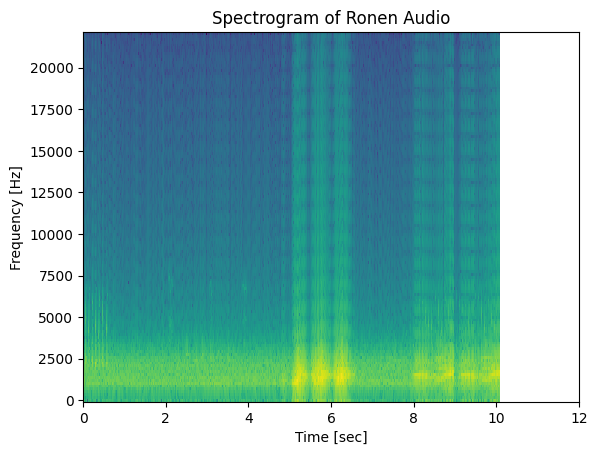

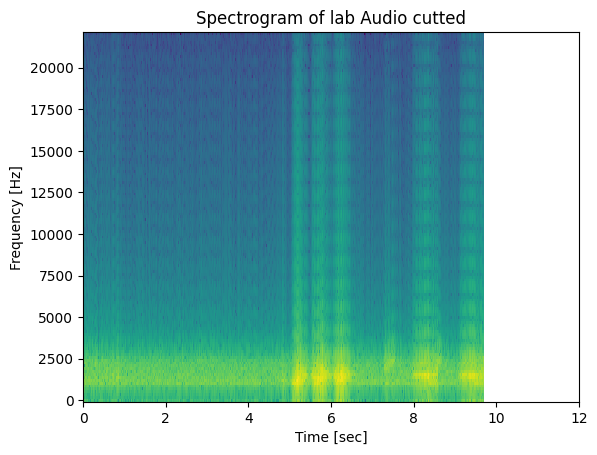

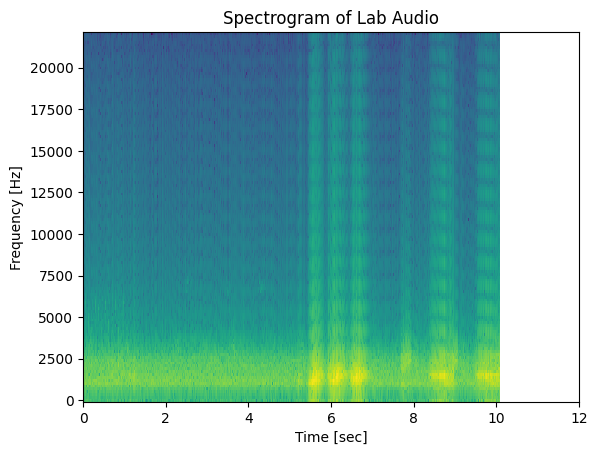

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def plot_spectrogram(audio, fs, title):
    f, t, Sxx = spectrogram(audio, fs)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, 12])
    plt.title(title)
    plt.show()


# Define the frequency range for bird noises
lowcut = 1000.0
highcut = 2500.0

# Load the videos and extract the audio
ronen_video, ronen_audio = load_video_and_extract_audio(ronen)
lab_video, lab_audio = load_video_and_extract_audio(lab)

# Convert to mono
ronen_audio = convert_to_mono(ronen_audio)
lab_audio_cut = convert_to_mono(lab_audio_cut)
lab_audio = convert_to_mono(lab_audio)

# Normalize the audio
ronen_audio = ronen_audio / np.max(np.abs(ronen_audio))
lab_audio_cut = lab_audio_cut / np.max(np.abs(lab_audio_cut))
lab_audio = lab_audio / np.max(np.abs(lab_audio))

# Apply the bandpass filter
ronen_audio = butter_bandpass_filter(ronen_audio, lowcut, highcut, SAMPLE_RATE, order=6)
lab_audio_cut = butter_bandpass_filter(lab_audio_cut, lowcut, highcut, SAMPLE_RATE, order=6)
lab_audio = butter_bandpass_filter(lab_audio, lowcut, highcut, SAMPLE_RATE, order=6)

# Plot the spectrograms
plot_spectrogram(ronen_audio, SAMPLE_RATE, 'Spectrogram of Ronen Audio')
plot_spectrogram(lab_audio_cut, SAMPLE_RATE, 'Spectrogram of lab Audio cutted')
plot_spectrogram(lab_audio, SAMPLE_RATE, 'Spectrogram of Lab Audio')

# Continue with the rest of your code...


## Data Loader

In [15]:
class VideoDataset(Dataset):
    def __init__(self, lab_dir, ronen_dir, labels_csv):
        self.lab_files = sorted(os.listdir(lab_dir))
        self.ronen_files = sorted(os.listdir(ronen_dir))
        self.lab_dir = lab_dir
        self.ronen_dir = ronen_dir

        # Load the labels from the CSV file
        self.labels = pd.read_excel(labels_csv, usecols=range(4)).set_index('filename')
        # Convert the labels to floats
        self.labels = self.labels.astype(float)

    def __len__(self):
        return len(self.lab_files)

    def __getitem__(self, idx):
        lab_file = self.lab_files[idx]
        ronen_file = self.ronen_files[idx]

        # Check that the files are correctly synchronized
        assert lab_file.split('_')[-1] == ronen_file.split('_')[-1], \
            f"Files are not synchronized: {lab_file}, {ronen_file}"

        # Load the videos using OpenCV
        lab_video = self.load_and_crop_video(os.path.join(self.lab_dir, lab_file))
        ronen_video = self.load_and_crop_video(os.path.join(self.ronen_dir, ronen_file))

        # Get the label for this video
        label = self.labels.loc[ronen_file, ['x', 'y', 'z']].values

        # Print out the label array
        print(f"Label for {ronen_file}: {label}")

        label = torch.tensor(label, dtype=torch.float)

        return lab_video, ronen_video, label

    def train_test_split_videos(self, test_size=0.2, random_state=None):
        # Discretize the labels into bins
        bins = pd.cut(self.labels['x'], bins=10)

        # Generate a sequence of indices from 0 to len(self) - 1
        indices = list(range(len(self)))

        # Split the indices into training indices and test indices
        train_indices, test_indices = train_test_split(
            indices, test_size=test_size, stratify=bins, random_state=random_state)

        # Create two new datasets: one for training and one for testing
        train_dataset = torch.utils.data.Subset(self, train_indices)
        test_dataset = torch.utils.data.Subset(self, test_indices)

        return train_dataset, test_dataset

    def load_and_crop_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []

        # Define the crop area (top, left, bottom, right)
        top, left, bottom, right = 0, 0, 285, 385

        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret:
                # Convert the frame from BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # Crop the frame
                frame = frame[top:bottom, left:right]
                frames.append(frame)
            else:
                break

        cap.release()

        # Convert the list of frames to a single numpy array
        frames = np.array(frames)

        # Convert the numpy array to a 4D tensor
        video = torch.from_numpy(frames)

        return video

In [7]:
lab_dir = os.path.join(models_path, "Recordings_22.5", "lab_synced")
ronen_dir = os.path.join(models_path, "Recordings_22.5", "ronen_synced")
labels_csv = os.path.join(models_path, "Recordings_22.5", "labels.xlsx")

# Instantiate the dataset
dataset = VideoDataset(lab_dir, ronen_dir, labels_csv)
# Split the dataset into a training set and a test set
train_dataset, test_dataset = dataset.train_test_split(test_size=0.2, random_state=42)

# Instantiate the data loader
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

Label for ronen_sync_video_71.webm: [-1.   0.   0.4]


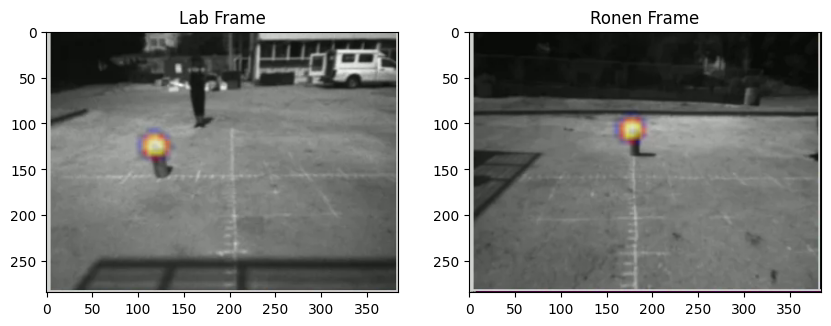

In [8]:
# Display a random frame from the dataset
display_random_frame(dataset)

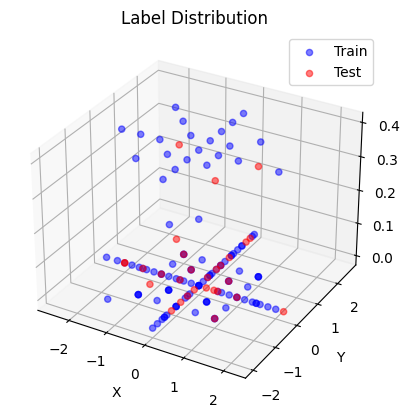

In [9]:
# Get the labels for the training set and the test set
train_labels = dataset.labels.iloc[train_dataset.indices]
test_labels = dataset.labels.iloc[test_dataset.indices]

# Plot the distributions of the labels in the training set and the test set
plot_labels(train_labels, test_labels)

In [10]:
import random
# Size of data
# [num_frames, x, y, num_color_channels]

# Get a random index
idx = random.randint(0, len(dataset) - 1)

# Get the videos and label at this index
lab_video, ronen_video, label = dataset[idx]

# Get the size of each frame (matrix) for the lab video
lab_frame_size = lab_video[0].shape

# Get the size of each frame (matrix) for the ronen video
ronen_frame_size = ronen_video[0].shape

# Get the size of the entire set of frames (video) for the lab video
lab_video_size = lab_video.shape

# Get the size of the entire set of frames (video) for the ronen video
ronen_video_size = ronen_video.shape

print(f"Size of each frame in lab video: {lab_frame_size}")
print(f"Size of lab video frames at index {idx}: {lab_video_size}")

print(f"\nSize of each frame in ronen video: {ronen_frame_size}")
print(f"Size of ronen video frames at index {idx}: {ronen_video_size}")

# [num_frames, x, y, num_color_channels]

Label for ronen_sync_video_74.webm: [ 0.  -0.5  0.4]
Size of each frame in lab video: torch.Size([285, 385, 3])
Size of lab video frames at index 113: torch.Size([245, 285, 385, 3])

Size of each frame in ronen video: torch.Size([285, 385, 3])
Size of ronen video frames at index 113: torch.Size([245, 285, 385, 3])


In [ ]:
# Find

# Models

In [11]:
# imports
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn.functional as F
from torchvision.models import resnet18, resnet101

In [17]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNLSTM, self).__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 300))
        self.lstm = nn.LSTM(input_size=600, hidden_size=256, num_layers=3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x_3d1, x_3d2):
        batch_size, timesteps, C, H, W = x_3d1.size()
        c_in = x_3d1.view(batch_size * timesteps, C, H, W)
        c_out = self.resnet(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)

        batch_size, timesteps, C, H, W = x_3d2.size()
        c_in = x_3d2.view(batch_size * timesteps, C, H, W)
        c_out = self.resnet(c_in)
        r_in2 = c_out.view(batch_size, timesteps, -1)

        r_in = torch.cat((r_in, r_in2), 2)

        out, _ = self.lstm(r_in)
        print('shape of out: ', out.shape)
        x = self.fc1(out[:, -1, :])  # get the last output
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Train

In [18]:
lab_dir = os.path.join(models_path, "Recordings_22.5", "lab_synced")
ronen_dir = os.path.join(models_path, "Recordings_22.5", "ronen_synced")
labels_csv = os.path.join(models_path, "Recordings_22.5", "labels.xlsx")

# Instantiate the dataset
dataset = VideoDataset(lab_dir, ronen_dir, labels_csv)
# Split the dataset into a training set and a test set
train_dataset, test_dataset = dataset.train_test_split_videos(test_size=0.2, random_state=42)

# Instantiate the data loader
trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTM(num_classes=3).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1
for epoch in range(num_epochs):
    for i, (video1, video2, labels) in enumerate(trainloader):
        video1, video2 = video1.permute(0, 1, 4, 2, 3), video2.permute(0, 1, 4, 2, 3)
        video1 = video1.float().to(device)
        video2 = video2.float().to(device)
        labels = labels.to(device)

        outputs = model(video1, video2)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 318MB/s]


Label for ronen_sync_video_7.webm: [1.2 0.  0. ]


OutOfMemoryError: ignored